# Plot areas where movements happened on the phones backside during the dragging task

In [1]:
import time
from datetime import datetime
import os
import math

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.path import Path
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import scipy.stats

from  sklearn.metrics import r2_score

%matplotlib inline

%run py/constants.py
%run py/take_processing_methods.py
%run py/marker_processing_methods.py
%run py/heatmap_methods.py
%run py/grasp_property_methods.py
%run py/rasterization_methods.py

In [2]:
%%time
seated = {"S3":[],"S4":[],"OPO":[],"N6":[]}
walking = {"S3":[],"S4":[],"OPO":[],"N6":[]}
dicts = {"seated":seated,"walking":walking}


path = "./DraggingPickles/"
for file in os.listdir(path):
    filepath  = path+file
    df = pd.read_pickle(filepath)
    pid, phone, cond = file.replace('.pkl',"").split("_")
    dicts[cond][phone].append(df)
for cond, ddict in dicts.items():
    for phone, df_list in ddict.items():
        ddict[phone] = pd.concat(df_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


CPU times: user 1.24 s, sys: 444 ms, total: 1.69 s
Wall time: 1.69 s


In [3]:
def getDeviceCoordinates(device):
    screen_pos = get_screen_pos(device)
    device_width_px = get_device_size(device)[0] /0.01
    device_height_px = get_device_size(device)[1] /0.01
    x = 0-screen_pos[0]
    y = 0-screen_pos[1]
    return (x, y), device_width_px, device_height_px

CPU times: user 53.9 s, sys: 14.6 ms, total: 53.9 s
Wall time: 53.9 s


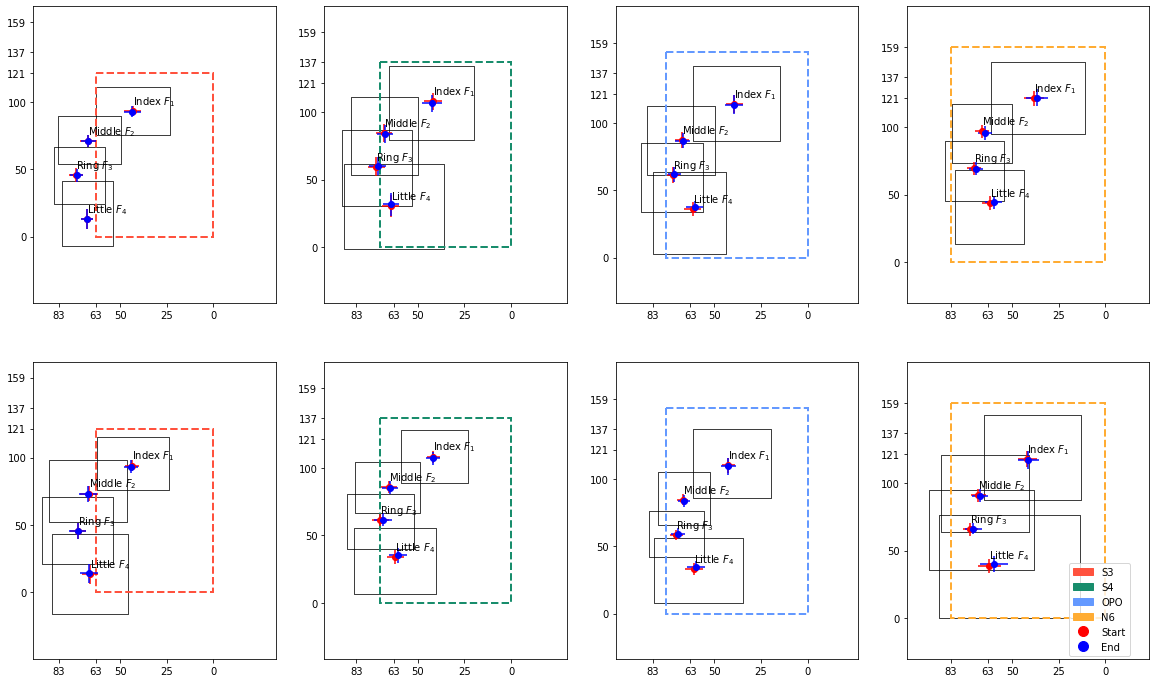

In [4]:
%%time
ratio = (140.0 - 20.0) / (215.0 - 40.0)
val_x = 6.5
val_y = 11

finger_text = [r"Index $F_1$",r"Middle $F_2$",r"Ring $F_3$",r"Little $F_4$"]#r"Thumb $F_0$",

seated_distances = {"S3":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "S4":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "OPO":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "N6":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]}}
walking_distances = {"S3":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "S4":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "OPO":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]},
                    "N6":{"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]}}
distance_dict = {"seated":seated_distances, "walking": walking_distances}
colors = ["r","g","b","y"]
c1 = ['#7b3294','#c2a5cf','#a6dba0','#008837']
c2 = ['#ca0020','#f4a582','#92c5de','#0571b0']
device_colors = ['#FF523E','#188D6C','#6499FF','#FFAC33']
phones = ["S3","S4","OPO","N6"]
patches = []

for i in range(len(colors)):
    patch = mpatches.Patch(color=device_colors[i], label=phones[i])
    patches.append(patch)

red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Start')   
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='End')

patches.append(red_dot)
patches.append(blue_dot)    


fig, ax = plt.subplots(2, 4, figsize=(20, 12))

devices = ['s3', 's4', 'opo', 'n6']
fingers = [ "Index", "Middle", "Ring", "Little"]#"Thumb",
j= "Fn"
ccounter = 0
for cond, ddict in dicts.items():
    dist_dict = distance_dict[cond]
    pcounter = 0
    #if cond != "walking":
        #continue
    for phone, df in ddict.items():
        for i,fi in enumerate(fingers):
            firstPoints = ([],[])
            all_xs = []
            all_ys = []
            lastPoints = ([],[])
            distances = []
            for Id in  df["Drag"].unique():
                
                f=(df["%s_%s_X"%(fi,j)]>df["%s_%s_X"%(fi,j)].mean()-df["%s_%s_X"%(fi,j)].std()*2)&\
                (df["%s_%s_X"%(fi,j)]<df["%s_%s_X"%(fi,j)].mean()+df["%s_%s_X"%(fi,j)].std()*2)&\
                (df["%s_%s_Y"%(fi,j)]>df["%s_%s_Y"%(fi,j)].mean()-df["%s_%s_Y"%(fi,j)].std()*2)&\
                (df["%s_%s_Y"%(fi,j)]<df["%s_%s_Y"%(fi,j)].mean()+df["%s_%s_Y"%(fi,j)].std()*2)
                #df.loc[~f,["%s_%s_X"%(fi,j),"%s_%s_Y"%(fi,j)]] = np.nan
                
                #partial_df = df[df["Drag"]==Id]
                #partial_df = df.dropna(subset = ["%s_%s_X"%(fi,j),"%s_%s_Y"%(fi,j)])
                
                xs = df[(df["Drag"]==Id)&f]["%s_%s_X"%(fi,j)].values
                ys = df[(df["Drag"]==Id)&f]["%s_%s_Y"%(fi,j)].values
                
                if len(xs)>0:
                    all_xs+=xs.tolist()
                    all_ys+=ys.tolist()
                    firstPoints[0].append(xs[0])
                    firstPoints[1].append(ys[0])
                    lastPoints[0].append(xs[-1])
                    lastPoints[1].append(ys[-1])
            
            # Calculate Distance between 
            first_x = firstPoints[0]
            first_y = firstPoints[1]
            last_x = lastPoints[0]
            last_y = lastPoints[1]
            for x0,y0,x1,y1 in zip(first_x,first_y,last_x,last_y):
                a = np.array([x0,y0])*100
                b = np.array([x1,y1])*100
                dist = np.sqrt(np.sum((a-b)**2, axis=0))
                dist_dict[phone][fi].append(dist)
                
            firstPoints = np.asarray(firstPoints)*100
            lastPoints = np.asarray(lastPoints)*100
            
            all_xs = np.array(all_xs)*100
            
            #all_xs = all_xs[(all_xs<all_xs.mean()+all_xs.std())&(all_xs>all_xs.mean()-all_xs.std()*2)]
            all_ys = np.array(all_ys)*100
            #all_ys = all_ys[(all_ys<all_ys.mean()+all_ys.std())&(all_ys>all_ys.mean()-all_ys.std()*2)]
            rect = mpatches.Rectangle((all_xs.min(),all_ys.max()),(all_xs.max()-all_xs.min()),(all_ys.min()-all_ys.max()),linewidth=0.5,edgecolor="black",facecolor='none')
            ax[ccounter, pcounter].add_patch(rect)
            ax[ccounter, pcounter].add_patch(rect)
            #x and y values for start and end points of longest movements
            firstPoint_x = firstPoints[0].mean()
            firstPoint_y = firstPoints[1].mean()
            lastPoint_x = lastPoints[0].mean()
            lastPoint_y = lastPoints[1].mean()
            firstPoint_x_std = firstPoints[0].std()/2
            firstPoint_y_std = firstPoints[1].std()/2
            lastPoint_x_std = lastPoints[0].std()/2
            lastPoint_y_std = lastPoints[1].std()/2
            
            ax[ccounter, pcounter].errorbar(firstPoints[0].mean(),firstPoints[1].mean(), yerr = firstPoint_y_std, xerr = firstPoint_x_std,fmt='o' ,c = "r")
            ax[ccounter, pcounter].errorbar(lastPoints[0].mean(),lastPoints[1].mean(), yerr = lastPoint_y_std, xerr = lastPoint_x_std,fmt='o' ,c = "b")
            ax[ccounter, pcounter].text(firstPoints[0].mean(),firstPoints[1].mean() - 0.5, finger_text[i])
            ax[ccounter, pcounter].plot([firstPoints[0].mean(),lastPoints[0].mean()],[firstPoints[1].mean(),lastPoints[1].mean()])
                
        tre, device_width_px, device_height_px = getDeviceCoordinates(phone.lower())
        scale_x = tre[0]+device_width_px/2
        scale_y = tre[1]+device_height_px/2
        
        n6_size = get_device_size('n6')*100
        opo_size = get_device_size('opo')*100
        s4_size = get_device_size('s4')*100
        s3_size = get_device_size('s3')*100
        rex = tre[0]+device_width_px
        lby = device_height_px+tre[1]
        ax[ccounter, pcounter].set_xticks([rex-n6_size[0],
                                             rex-s3_size[0],
                                             rex-5,
                                             rex-2.5,
                                             rex])
        ax[ccounter, pcounter].set_xticklabels([int(n6_size[0]*10), int(s3_size[0]*10), "50", "25", "0"])
        
        ax[ccounter, pcounter].set_yticks([lby-n6_size[1],
                                             lby-s4_size[1],
                                             lby-s3_size[1],
                                             lby-10,
                                             lby-5,
                                             lby])
        ax[ccounter, pcounter].set_yticklabels([int(n6_size[1]*10), int(s4_size[1]*10), int(s3_size[1]*10), "100", "50", "0"])

        
        ax[ccounter, pcounter].set_ylim(scale_y+val_y,scale_y-val_y)
        ax[ccounter, pcounter].set_xlim(scale_x-val_x,scale_x+val_x)
        rect = mpatches.Rectangle(tre ,device_width_px,device_height_px,linewidth=2,edgecolor=device_colors[pcounter],linestyle = '--',facecolor='none')
        ax[ccounter, pcounter].add_patch(rect)            
        pcounter+=1
    ccounter+=1

plt.legend(bbox_to_anchor=(0.67,0.01,1,0.2), loc="lower left", handles= patches, ncol = 1, borderaxespad=0)


# Plot for fitted function to the 95% values of the length of the movements 

Exporting to ./figures/longest_movements_seated.pdf


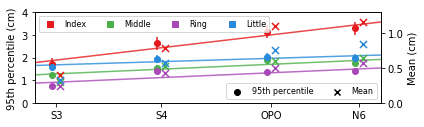

Exporting to ./figures/longest_movements_walking.pdf


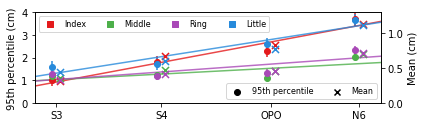

In [15]:
conditions = ["seated","walking"]
phones = ["S3","S4","OPO","N6"]
fingers = ["Index", "Middle", "Ring", "Little"]#"Thumb"
colors = ['#e41a1c','#4daf4a','#a949b7', '#278adb']

#colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']

#x = [4,4.6,5.49,5.96]
x = [76.61, 95.90,116.05,132.22]
x_new = np.arange(x[0]-4, x[-1]+5, 1)
lstx =[0,2, 3, 1]

r2s = []

for y,cond in enumerate(conditions):
    fig, ax1 = plt.subplots(1, figsize=(6, 1.85))
    ax2 = ax1.twinx()
    lstLegend = []
    for i,finger in enumerate(fingers):
        percentiles = []
        means = []
        for k,phone in enumerate(phones):
            #print(len(distance_dict[cond][phone][finger])/16)
            f_list = np.array(distance_dict[cond][phone][finger])
            f_list = np.sort(f_list)
            percentile = f_list[int(len(f_list)*0.95)]
            means.append(f_list.mean())
            percentiles.append(percentile)
        ax1.errorbar(np.array(x)-.75,percentiles, c=colors[i], yerr=f_list.std()/np.sqrt(16), marker="o", ls="none")
        ax1.scatter(-5, -5, c=colors[i], marker="s", label = finger)
        coefs = poly.polyfit(x, percentiles, 1)
        r2 = r2_score(percentiles, poly.polyval(x, coefs)).round(2)
        r2s.append(r2)
        tx = x[1]+(x[2]-x[1])/2.0
        ty = poly.polyval(tx, coefs)+0.1
        tx = tx-(lstx[i]*2)
        #ax1.annotate("$R^2=%.2f$"% r2, (tx,ty))
        ffit = poly.polyval(x_new, coefs)
        ax1.plot(x_new, ffit, c = colors[i], alpha=0.8)
        
        
        ax2.scatter(np.array(x)+.75, means, marker = "x", c=colors[i], s=50)#, label = finger)
        
    
    
    
    #ax1.scatter(-5, -5, c="k", marker="s", label="Mean")
    condLbl = ["Sitting", "Walking"]
    #ax1.text(0.025, 0.71, condLbl[y], transform=ax1.transAxes, fontsize=8, verticalalignment='top')
    ax2.scatter(-5, -5, c="k", marker="o", label="95th percentile")
    ax2.scatter(-5, -5, c="k", marker="x", label="Mean")
    
    
    ax2.set_ylim(0,1.3)
    ax1.legend(ncol=4, loc=2,  fontsize=8)
    ax2.legend(ncol=2, loc=4,  fontsize=8)#, title="Mean")
    plt.xticks(x)
    plt.xlim(x[0]-4, x[-1]+4)
    ax1.set_ylim(0,4.)
    ax1.set_xticklabels(phones)
    filepath = "./figures/longest_movements_%s.pdf"%cond
    print("Exporting to %s"%filepath)
    ax1.set_ylabel("95th percentile (cm)")
    ax2.set_ylabel("Mean (cm)")
    fig.tight_layout()
    plt.savefig(filepath, bbox_inches='tight')
    plt.show()

In [6]:
np.array(r2s).mean()

0.74625

In [7]:
r2_score(x, poly.polyval(x, coefs))

-24.062145002576624

In [8]:
f_list.mean()

1.1234779265814197

### Values for describing the movement lengths on the phone's backsides

In [9]:
for cond, cond_dict in distance_dict.items():
    for phone , f_dict in cond_dict.items():
        for finger, f_list in f_dict.items():
            if finger != "Thumb":
                print(cond,phone,finger,len(f_list))
                f_list = np.array(f_list)
                f_list = np.sort(f_list)
                percentile = f_list[int(len(f_list)*0.95)]
                print("%s | %s - %s  M: %scm (%s) | Min: %scm | Max: %scm | 95%% percentile: %scm"%(cond, phone, finger, "%.2f"%f_list.mean(),"%.2f"%f_list.std(),"%.2f"%f_list.min(),"%.2f"%f_list.max(),percentile.round(2)) )
        print("________________________\n")

seated S3 Index 159
seated | S3 - Index  M: 0.40cm (0.51) | Min: 0.00cm | Max: 2.29cm | 95% percentile: 1.72cm
seated S3 Middle 162
seated | S3 - Middle  M: 0.30cm (0.35) | Min: 0.01cm | Max: 1.81cm | 95% percentile: 1.21cm
seated S3 Ring 158
seated | S3 - Ring  M: 0.23cm (0.25) | Min: 0.00cm | Max: 1.82cm | 95% percentile: 0.73cm
seated S3 Little 157
seated | S3 - Little  M: 0.33cm (0.45) | Min: 0.00cm | Max: 2.24cm | 95% percentile: 1.58cm
________________________

seated S4 Index 158
seated | S4 - Index  M: 0.78cm (0.75) | Min: 0.02cm | Max: 3.87cm | 95% percentile: 2.62cm
seated S4 Middle 157
seated | S4 - Middle  M: 0.52cm (0.53) | Min: 0.00cm | Max: 3.30cm | 95% percentile: 1.52cm
seated S4 Ring 161
seated | S4 - Ring  M: 0.43cm (0.49) | Min: 0.00cm | Max: 2.73cm | 95% percentile: 1.38cm
seated S4 Little 157
seated | S4 - Little  M: 0.57cm (0.63) | Min: 0.00cm | Max: 3.77cm | 95% percentile: 1.94cm
________________________

seated OPO Index 161
seated | OPO - Index  M: 1.11cm (0.

### Pearsons correlation between diagonal lenth of device and average movement lengths

In [10]:
# Means of fingers in distance dict
distances_seated = [[2.54,4.14,4.57,4.93],[0.40,0.78,1.11,1.16],[0.30,0.52,0.60,0.65],[0.23,0.43,0.50,0.56],[0.33,0.57,0.76,0.85]]
distances_walking = [[2.46,3.83,4.32,4.37],[0.32,0.67,0.83,1.13],[0.35,0.47,0.45,0.70],[0.33,0.42,0.45,0.71],[0.44,0.59,0.77,1.12]]
distance_pearson = {"seated":distances_seated,"walking":distances_walking}

fingers = ["Thumb", "Index", "Middle", "Ring", "Little"]
devices = ['s3', 's4', 'opo', 'n6']
dig_sizes = []
for d in devices:
    si = get_device_size(d)

    diagonal = math.sqrt(si[0]**2 + si[1]**2)
    dig_sizes.append(diagonal)
    # print str(diagonal).replace(".", ",")
dig_sizes = np.array(dig_sizes)

for cond, cond_distance in distance_pearson.items():
    for i, finger_dist in enumerate(cond_distance):
        r, p = scipy.stats.pearsonr(dig_sizes, finger_dist)
        r_s = math.pow(r,2)
        print(r"%s | %s | r : %s | $r^2$ = %s | p: %s "%(cond, fingers[i], str("%.3f" % r),str("%.3f" % r_s),str("%.3f" % p)))

seated | Thumb | r : 0.957 | $r^2$ = 0.916 | p: 0.043 
seated | Index | r : 0.988 | $r^2$ = 0.976 | p: 0.012 
seated | Middle | r : 0.969 | $r^2$ = 0.940 | p: 0.031 
seated | Ring | r : 0.974 | $r^2$ = 0.948 | p: 0.026 
seated | Little | r : 0.997 | $r^2$ = 0.995 | p: 0.003 
walking | Thumb | r : 0.942 | $r^2$ = 0.888 | p: 0.058 
walking | Index | r : 0.981 | $r^2$ = 0.962 | p: 0.019 
walking | Middle | r : 0.840 | $r^2$ = 0.706 | p: 0.160 
walking | Ring | r : 0.868 | $r^2$ = 0.754 | p: 0.132 
walking | Little | r : 0.942 | $r^2$ = 0.888 | p: 0.058 
